In [2]:
import sys
sys.path.append('..')

import os
project_root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))

import pandas as pd
from training import TrainingManager, TrainingConfig
from envs.trading_env import MyTradingEnv

N_EPISODES = 100


In [3]:

from agents.classical.qlearning_agent import QLearningAgent

data_path = "../data/data_1h_2023.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")

agent = QLearningAgent()
env = MyTradingEnv(df=df)

config = TrainingConfig(
    agent_name="QLearning_v1",
        agent_type="QLearning",
        n_episodes=N_EPISODES,
        max_steps=1000,
        learning_rate=0.1,
        discount_factor=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995,
        eval_frequency=100,
        save_frequency=500
)

manager = TrainingManager(
    base_log_dir=os.path.join(project_root, "training_data/logs"),
    base_checkpoint_dir=os.path.join(project_root, "training_data/checkpoints")
)
results = manager.train_agent(agent, env, config, experiment_name="exp_qlearn_v1")


Начало обучения: QLearning_v1
Эксперимент: exp_qlearn_v1
Эпизодов: 100
Learning rate: 0.1
Discount factor: 0.99

Episode 100/100
  Train Reward: -68.71 | Avg100: -132.81
  Eval Reward: -39.37 ± 0.00
  Epsilon: 0.6058 | Q-table: 72 states
  Trades: 155 | Win Rate: 38.7%
  Portfolio: $1093.16

Агент сохранён: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/checkpoints/exp_qlearn_v1/final_agent.pkl

✓ Логи сохранены в: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/logs/exp_qlearn_v1

Обучение завершено!
Время обучения: 0.28 минут
Финальная награда: -68.71
Размер Q-таблицы: 72 состояний



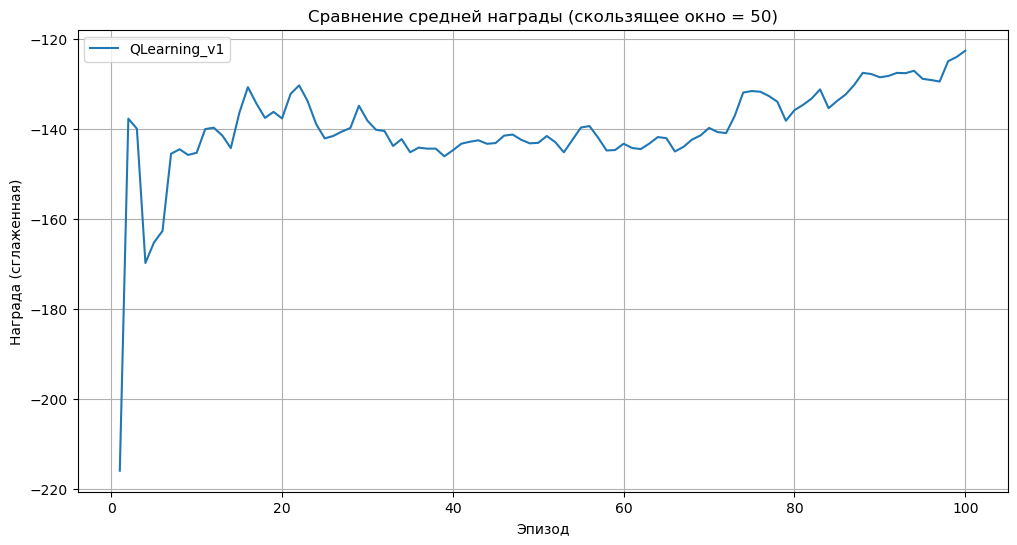

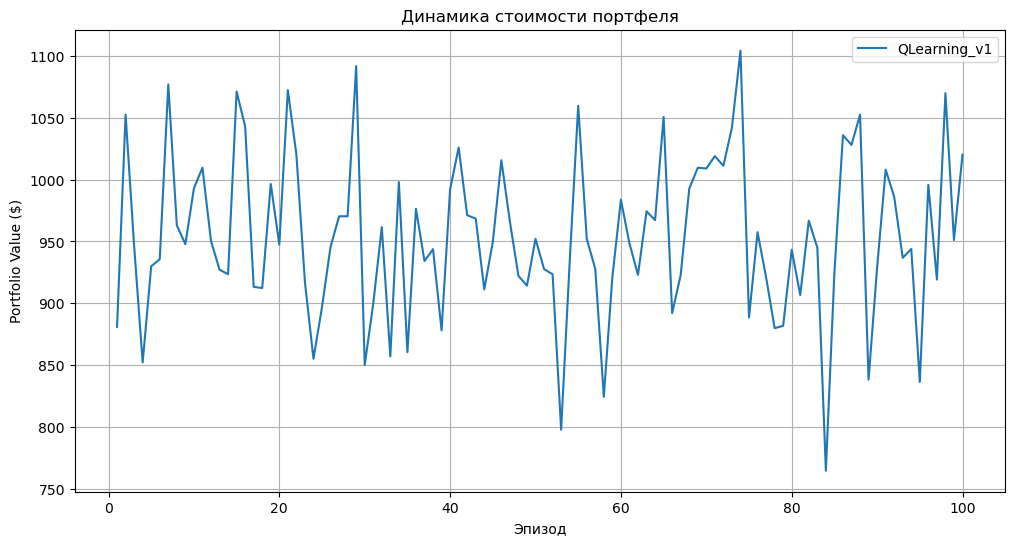

,agent,reward,portfolio_value,win_rate,n_trades,max_drawdown
99,QLearning_v1,-68.71,1020.15,38.71,155,0.03


In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

experiment_dirs = [
    "../training_data/logs/exp_qlearn_v1",
    # "../training_data/logs/exp_sarsa_v1",
]

all_data = []
for exp_dir in experiment_dirs:
    exp_dir = Path(exp_dir)
    episodes_df = pd.read_csv(exp_dir / "episodes.csv")
    with open(exp_dir / "training_summary.json") as f:
        summary = json.load(f)
    agent_name = summary["config"]["agent_name"]
    episodes_df["agent"] = agent_name
    all_data.append(episodes_df)


df = pd.concat(all_data, ignore_index=True)

plt.figure(figsize=(12, 6))
for agent in df["agent"].unique():
    agent_data = df[df["agent"] == agent]
    smoothed = agent_data["reward"].rolling(window=50, min_periods=1).mean()
    plt.plot(agent_data["episode"], smoothed, label=agent)

plt.title("Сравнение средней награды (скользящее окно = 50)")
plt.xlabel("Эпизод")
plt.ylabel("Награда (сглаженная)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
for agent in df["agent"].unique():
    agent_data = df[df["agent"] == agent]
    plt.plot(agent_data["episode"], agent_data["portfolio_value"], label=agent)

plt.title("Динамика стоимости портфеля")
plt.xlabel("Эпизод")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()


final_metrics = df.groupby("agent").tail(1)[
    ["agent", "reward", "portfolio_value", "win_rate", "n_trades", "max_drawdown"]
]
display(final_metrics.round(2))